###Getting Data into Google Colab

In [ ]:
from google.colab import files
files.upload()

MessageError: ignored

In [ ]:
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("data")
new_dir = pathlib.Path("Sorted_Data")

def make_subset(subset_name, start_index, end_index):
    for category in ("circle", "digits", "triangle"):
        dir = new_dir / subset_name / category
        os.makedirs(dir, exist_ok = True)
        fnames = [f"{category}_{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=100)
make_subset("validation", start_index=100, end_index=300)
make_subset("test", start_index=300, end_index=1000)

###Preprocess Data

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory


length = 100
height = 100

train_dataset = image_dataset_from_directory(
    new_dir / "train",
    label_mode = "categorical",
    image_size=(length, height),
    batch_size=50)
validation_dataset = image_dataset_from_directory(
    new_dir / "validation",
    label_mode = "categorical",
    image_size=(length, height),
    batch_size=50)
test_dataset = image_dataset_from_directory(
    new_dir / "test",
    label_mode = "categorical",
    image_size=(length, height),
    batch_size=50)

Found 300 files belonging to 3 classes.
Found 1200 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (50, 100, 100, 3)
labels batch shape: (50, 3)


###The Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(length, height, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=10, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=25, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=50, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_47 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_172 (Conv2D)         (None, 98, 98, 10)        280       
                                                                 
 max_pooling2d_124 (MaxPooli  (None, 49, 49, 10)       0         
 ng2D)                                                           
                                                                 
 conv2d_173 (Conv2D)         (None, 47, 47, 25)        2275      
                                                                 
 max_pooling2d_125 (MaxPooli  (None, 23, 23, 25)       0         
 ng2D)                                                    

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
6/6 [==============================] - 2s 329ms/step - loss: 1.2960 - accuracy: 0.3933 - val_loss: 1.1237 - val_accuracy: 0.3333
Epoch 2/30
6/6 [==============================] - 2s 304ms/step - loss: 1.0247 - accuracy: 0.4367 - val_loss: 0.9716 - val_accuracy: 0.6208
Epoch 3/30
6/6 [==============================] - 2s 308ms/step - loss: 0.8588 - accuracy: 0.7333 - val_loss: 0.7932 - val_accuracy: 0.6525
Epoch 4/30
6/6 [==============================] - 2s 304ms/step - loss: 0.6616 - accuracy: 0.7200 - val_loss: 0.5577 - val_accuracy: 0.7967
Epoch 5/30
6/6 [==============================] - 2s 307ms/step - loss: 0.4368 - accuracy: 0.8267 - val_loss: 0.4123 - val_accuracy: 0.8333
Epoch 6/30
6/6 [==============================] - 2s 306ms/step - loss: 0.3004 - accuracy: 0.8967 - val_loss: 0.2984 - val_accuracy: 0.8883
Epoch 7/30
6/6 [==============================] - 2s 303ms/step - loss: 0.2304 - accuracy: 0.9233 - val_loss: 0.2705 - val_accuracy: 0.8925
Epoch 8/30
6/6 [====

###Evaluation

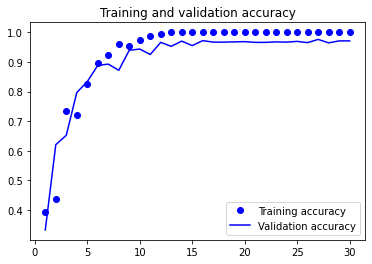

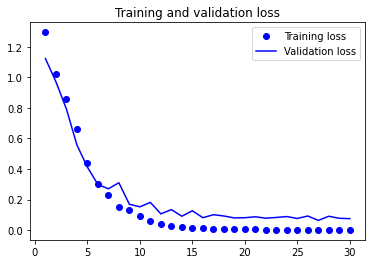

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

30/30 [==============================] - 2s 48ms/step - loss: 0.0884 - accuracy: 0.9727
Test accuracy: 0.973


In [ ]:
import numpy as np

# Get all images and targets
all_data = test_dataset.concatenate( train_dataset )
all_data = all_data.concatenate( validation_dataset )

# Seperate images and targets
first = True
for data, target in all_data:
  if first:
    targets = target.numpy()
    images = data
    first = False

  else:
    targets = np.vstack( ( targets, target.numpy() ) )
    images = np.vstack( ( images, data ) )


In [ ]:
# Convert images to predictions
preds = test_model.predict( images )

# Convert predictions to integer values, with a one in the highest prediction
dif = 1 - np.max( preds, 1 )
preds = np.floor( preds + np.stack( ( dif, dif, dif ), axis = 1 ) )

94/94 [==============================] - 0s 4ms/step


In [ ]:
# Get predictions in format needed for confusion matrix
con_pred = np.dstack( (preds, preds, preds) )

# Get targets in format needed for confusion matrix
con_targets = np.stack( (targets, targets, targets), 1 )


# Make confusion matrix for each image
con_matrix = np.array( con_pred , dtype="int32") & np.array( con_targets, dtype = "int32" )

# Combine all confusion matrices
con_matrix = con_matrix.sum(0) 

print(con_matrix)


[[987   0  27]
 [  0 971   1]
 [ 13  29 972]]


In [ ]:
# Convert con_matrix to strings of a set width
def format( number ):
  return str(number).rjust( 4, " ")

con_values = []  
con_values.append( list( map( format, con_matrix[0]) ) )
con_values.append( list( map( format, con_matrix[1]) ) )
con_values.append( list( map( format, con_matrix[2]) ) )

# Print confusion matrix
print( f''' 
                       Actual

                    C      D      T
                ┌───────────────────
              C │ {con_values[0][0]}   {con_values[0][1]}   {con_values[0][2]}
                │
Predictions   D │ {con_values[1][0]}   {con_values[1][1]}   {con_values[1][2]}
                │
              T │ {con_values[2][0]}   {con_values[2][1]}   {con_values[2][2]}
 
''')

 
                       Actual

                    C      D      T
                ┌───────────────────
              C │  987      0     27
                │
Predictions   D │    0    971      1
                │
              T │   13     29    972
 



###VGG16 Model

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
inputs = keras.Input(shape=(length, height, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0002),
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
6/6 [==============================] - 4s 632ms/step - loss: 6.8840 - accuracy: 0.3400 - val_loss: 3.5663 - val_accuracy: 0.4883
Epoch 2/20
6/6 [==============================] - 3s 597ms/step - loss: 3.0101 - accuracy: 0.5933 - val_loss: 1.5624 - val_accuracy: 0.7200
Epoch 3/20
6/6 [==============================] - 3s 554ms/step - loss: 1.4325 - accuracy: 0.7433 - val_loss: 0.8649 - val_accuracy: 0.8367
Epoch 4/20
6/6 [==============================] - 3s 602ms/step - loss: 0.7364 - accuracy: 0.8500 - val_loss: 0.4561 - val_accuracy: 0.9150
Epoch 5/20
6/6 [==============================] - 3s 603ms/step - loss: 0.4857 - accuracy: 0.9033 - val_loss: 0.2686 - val_accuracy: 0.9492
Epoch 6/20
6/6 [==============================] - 3s 600ms/step - loss: 0.1443 - accuracy: 0.9500 - val_loss: 0.1897 - val_accuracy: 0.9650
Epoch 7/20
6/6 [==============================] - 3s 597ms/step - loss: 0.1070 - accuracy: 0.9667 - val_loss: 0.1409 - val_accuracy: 0.9725
Epoch 8/20
6/6 [====

###VGG16 Evaluation

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

30/30 [==============================] - 3s 72ms/step - loss: 0.0517 - accuracy: 0.9880
Test accuracy: 0.988


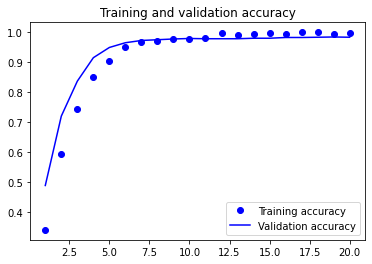

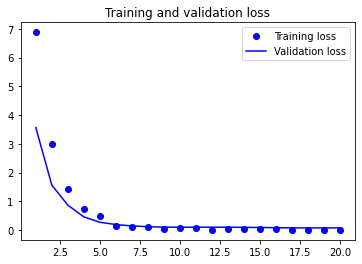

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# Convert images to predictions
preds = test_model.predict( images )

# Convert predictions to integer values, with a one in the highest prediction
dif = 1 - np.max( preds, 1 )
preds = np.floor( preds + np.stack( ( dif, dif, dif ), axis = 1 ) )

94/94 [==============================] - 3s 35ms/step


In [ ]:
# Get predictions in format needed for confusion matrix
con_pred = np.dstack( (preds, preds, preds) )

# Get targets in format needed for confusion matrix
con_targets = np.stack( (targets, targets, targets), 1 )

# Make confusion matrix for each image
con_matrix = np.array( con_pred , dtype="int32") & np.array( con_targets, dtype = "int32" )

# Combine all confusion matrices
con_matrix = con_matrix.sum(0) 

print(con_matrix)

[[998   2   0]
 [  1 967   3]
 [  1  31 997]]


In [ ]:
# Convert con_matrix to strings of a set width
def format( number ):
  return str(number).rjust( 4, " ")

con_values = []  
con_values.append( list( map( format, con_matrix[0]) ) )
con_values.append( list( map( format, con_matrix[1]) ) )
con_values.append( list( map( format, con_matrix[2]) ) )

# Print confusion matrix
print( f''' 
                       Actual

                    C      D      T
                ┌───────────────────
              C │ {con_values[0][0]}   {con_values[0][1]}   {con_values[0][2]}
                │
Predictions   D │ {con_values[1][0]}   {con_values[1][1]}   {con_values[1][2]}
                │
              T │ {con_values[2][0]}   {con_values[2][1]}   {con_values[2][2]}
 
''')

 
                       Actual

                    C      D      T
                ┌───────────────────
              C │  998      2      0
                │
Predictions   D │    1    967      3
                │
              T │    1     31    997
 

